<a href="https://colab.research.google.com/github/r357/Econometrics2/blob/master/Seminar6_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 6: Time Series 1
[Download stata data](https://github.com/r357/Econometrics2/blob/master/6_Time%20Series/6_SBITop_030406_2203133.dta
)

*(example lists and links:)*

* [**ADF - Augmented Dickey-Fuller test**](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) and [example](https://machinelearningmastery.com/time-series-data-stationary-python/)
* test2 link2


***
###ARIMA (p,d,q)
* AR - Autoregressive *(p: lag length)*
* I - Integration *(d: order of integration)*
* MA - Moving average *(q: length of moving average window)*

#### Process:
1.   To determine lag order: minimize information criteria.
$$ AIC = T \times \ln(\dfrac{RSS}{T}) + 2 \times k $$
*(model fit + penalty term for overfitting)*

2.  AIC (Akaike) asympotically overfits  - Might want to use BIC (Bayesian/Schwarz):
$$ BIC = T \times \ln(\dfrac{RSS}{T}) + k \times \ln(T) $$


2.   After model selection, test for residual autocorrelation (biased and inefficient estimates).
3.   If residual autocorrelation is present, select new model (determine new lag order)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import statsmodels.tsa.api as smt

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
# Download data from GitHub
!wget https://github.com/r357/Econometrics2/raw/master/6_Time%20Series/6_SBITop_030406_2203133.dta -q

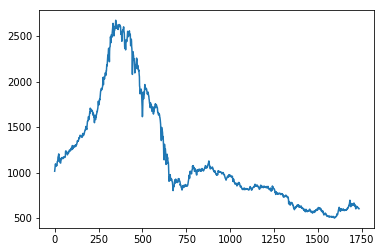

In [0]:
df = pd.read_stata("/content/6_SBITop_030406_2203133.dta")
df["t"] = range(1, len(df)+1)
df.sbitop.plot();

## Stationarity Tests & Data Transformations


### ADF test (Unit root test)

$ y_t = \alpha + \rho y_{t-1} + u_t $

H0: $\rho = 1$ (Unit root)

H1: $\rho < 1$ (Stationarity)

***
$ y_t -  y_{t-1} = \alpha  y_{t-1} -  y_{t-1} + u_t $

$ \Delta y_t = \alpha +(\rho -1) y_{t-1} + u_t $

$ \Delta y_t = \alpha +\sigma y_{t-1} + u_t $

H0: $\sigma = 0$

H1: $\sigma < 0$

***
Don't reject: $t > DF^{CRIT}$ (Unit root)

Reject: $t < DF^{CRIT}$ (Stationarity - no unit root)

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.


In [0]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.sbitop)

print('ADF Test p-value: %f' % result[1])

ADF Test p-value: 0.840613


ADF Test returns p-value of 0.84. We do not reject the null, and thus can not state that the time series is stationary.** Time series is not stationary. **Transformation in necessary in order to reject the existence of a unit root.



```
H0: "sbitop has a unit root" cannot be rejected (our time series is not stationary). 
```



###Transformations


1.   Log transformation
2.   Detrending
3.   Differences
4.   Log differences - transform to growth rates
5.   Apply a time series filter (HP filter)


In [0]:
# Function to display ADF statistic
def ADF(x):
    adf = adfuller(x)
    print("ADF p-value:", format(adf[1], 'f'))

#### Log transform

ADF p-value: 0.920034


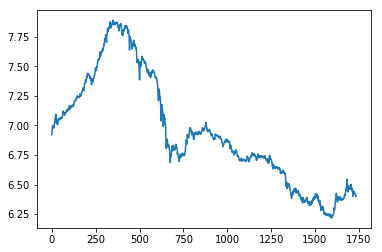

In [0]:
df["ln_sbitop"] = np.log(df["sbitop"])
# df.fillna(0, inplace=True)

adf = ADF(df["ln_sbitop"])

df.ln_sbitop.plot();

#### Detrend

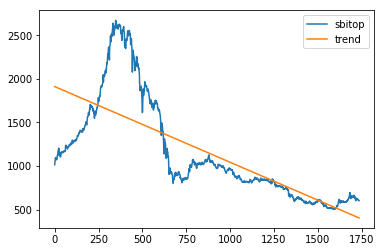

In [0]:
regress = smf.ols("sbitop ~ t", df).fit()
df["trend"] = regress.predict(df["t"])

df[["sbitop", "trend"]].plot();

ADF p-value: 0.235979


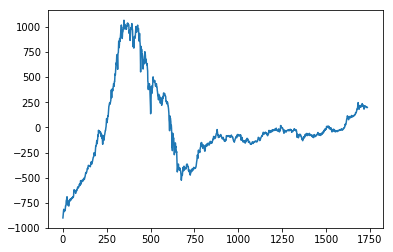

In [0]:
df["detrend_sbitop"] = df["sbitop"] - df["trend"]
adf = ADF(df["detrend_sbitop"])

df.detrend_sbitop.plot();

#### Differences

ADF p-value: 0.235979


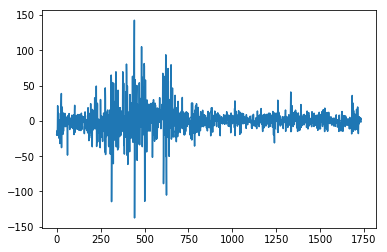

In [0]:
df["d_sbitop"] = df["sbitop"] - df["sbitop"].shift(-1)
ADF(df["detrend_sbitop"])

df.d_sbitop.plot();

#### Log differences (Growth rate)

ADF p-value: 0.000000


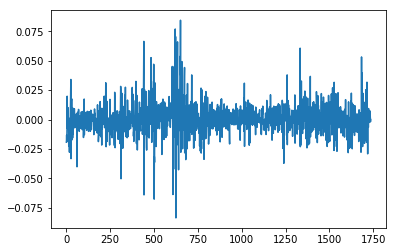

In [0]:
df["r"] = df["ln_sbitop"] - df["ln_sbitop"].shift(-1)
df.fillna(0, inplace=True)

ADF(df["r"])

df["r"].plot();

We finally reject the null (H0: unit root is present) and conclude that the time series is stationary when log-differences are used (for this example).

#### HP Filter

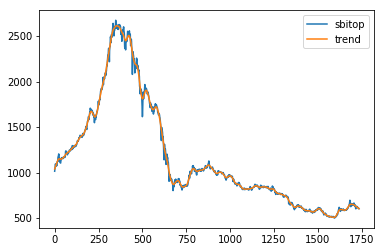

In [0]:
from statsmodels.tsa.filters.hp_filter import hpfilter
# smoothing parameter lambda=1600 as we're dealing with daily data (Ravn-Uhlig)

cycle, trend = hpfilter(df["sbitop"], 1600)
df["trend"] = trend
df["hp_sbitop"] = cycle

df[["sbitop", "trend"]].plot();

ADF p-value: 0.000000


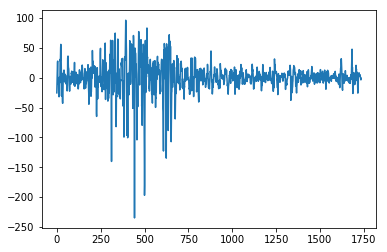

In [0]:
ADF(df.hp_sbitop)
df.hp_sbitop.plot();

## Identification of ARIMA models

ARIMA(1,0,0) = ARMA(1,0) = AR(1)

### Graph (Partial) Autocorrelations for sbitop and growth rates

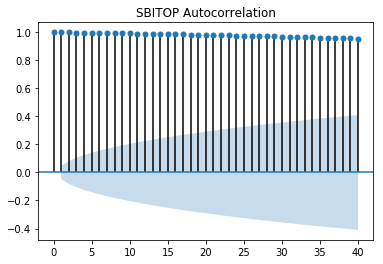

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.sbitop, lags=40, title="SBITOP Autocorrelation");

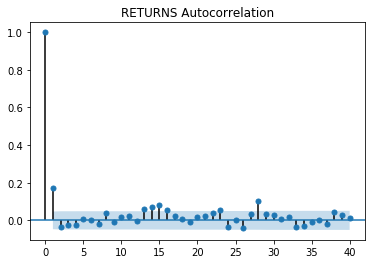

In [0]:
plot_acf(df.r, lags=40, title="RETURNS Autocorrelation");

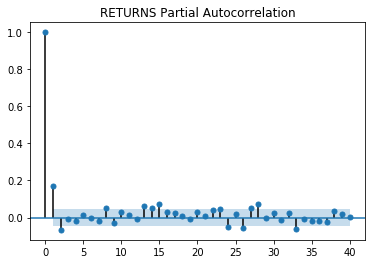

In [0]:
plot_pacf(df.r, lags=40, title="RETURNS Partial Autocorrelation");

### AR, ARMA, and ARIMA Models

In [0]:
# Prepare df for arima (needs datetime index)
df.index = pd.DatetimeIndex(end=pd.datetime.today(), periods=len(df), freq='1D')
# df.head()

#### AR(p)

In [0]:
# Regress return on lagged return
df["lag_r"] = df["r"].shift(-1)
Rreg = smf.ols("r ~ lag_r", df).fit()

# AR(1)
Rar_1 = smt.AR(df.r).fit(maxlag=1)

# Print statistics
print(summary_col([Rreg, Rar_1], 
                  model_names=["Shift", "AR(1)"]))


           Shift    AR(1)  
---------------------------
Intercept 0.0002           
          (0.0003)         
L1.r               0.1710  
                   (0.0237)
const              0.0003  
                   (0.0003)
lag_r     0.1712           
          (0.0237)         
Standard errors in
parentheses.


Clearly, models are almost identical. Discrepancies can be attributed to rounding errors.

In [0]:
Rar_optAIC = smt.AR(df.r).select_order(maxlag=5, ic="aic", trend='c', method='mle')
Rar_optBIC = smt.AR(df.r).select_order(maxlag=5, ic="bic", trend='c', method='mle')
print("Lag order based on AIC = ", Rar_optAIC)
print("Lag order based on BIC = ", Rar_optBIC)

Lag order based on AIC =  2
Lag order based on BIC =  1


#### ARMA(p, q)

In [0]:
# ARMA(1,0)
Rarma_10 = smt.ARMA(df.r, order=(1,0)).fit()
print(Rarma_10.summary())

                              ARMA Model Results                              
Dep. Variable:                      r   No. Observations:                 1736
Model:                     ARMA(1, 0)   Log Likelihood                5121.050
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 10 Apr 2019   AIC                         -10236.100
Time:                        09:17:20   BIC                         -10219.722
Sample:                    07-10-2014   HQIC                        -10230.043
                         - 04-10-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.813      0.416      -0.000       0.001
ar.L1.r        0.1711      0.024      7.232      0.000       0.125       0.217
                                    Roots           

In [0]:
# ARMA(1,1)
Rarma_11 = smt.ARMA(df.r, order=(1,1)).fit()
print(Rarma_11.summary())

                              ARMA Model Results                              
Dep. Variable:                      r   No. Observations:                 1736
Model:                     ARMA(1, 1)   Log Likelihood                5124.429
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 10 Apr 2019   AIC                         -10240.857
Time:                        09:17:24   BIC                         -10219.020
Sample:                    07-10-2014   HQIC                        -10232.781
                         - 04-10-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.849      0.396      -0.000       0.001
ar.L1.r       -0.1341      0.118     -1.137      0.256      -0.365       0.097
ma.L1.r        0.3173      0.113      2.816      0.0

#### ARIMA(p, q, d)

In [0]:
Rarima_101 = smt.ARIMA(df.r, order=(1,0,1)).fit()
print(Rarima_101.summary())

                              ARMA Model Results                              
Dep. Variable:                      r   No. Observations:                 1736
Model:                     ARMA(1, 1)   Log Likelihood                5124.429
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 10 Apr 2019   AIC                         -10240.857
Time:                        09:17:28   BIC                         -10219.020
Sample:                    07-10-2014   HQIC                        -10232.781
                         - 04-10-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.849      0.396      -0.000       0.001
ar.L1.r       -0.1341      0.118     -1.137      0.256      -0.365       0.097
ma.L1.r        0.3173      0.113      2.816      0.0

In [0]:
LNarima_111 = smt.ARIMA(df.ln_sbitop, order=(1,1,1)).fit()
print(LNarima_111.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.ln_sbitop   No. Observations:                 1735
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5120.977
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 10 Apr 2019   AIC                         -10233.954
Time:                        09:17:30   BIC                         -10212.119
Sample:                    07-11-2014   HQIC                        -10225.879
                         - 04-10-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0003      0.000     -0.848      0.396      -0.001       0.000
ar.L1.D.ln_sbitop    -0.1341      0.118     -1.137      0.256      -0.365       0.097
ma.L1.D.ln_sbitop     0.

In [0]:
print(summary_col([Rarima_101, LNarima_111], 
                   model_names=["Returns ARMA(1,1)", "ln price ARIMA(1,1,1)"]))


                  Returns ARMA(1,1) ln price ARIMA(1,1,1)
---------------------------------------------------------
ar.L1.D.ln_sbitop                   -0.1341              
                                    (0.1180)             
ar.L1.r           -0.1341                                
                  (0.1180)                               
const             0.0003            -0.0003              
                  (0.0004)          (0.0004)             
ma.L1.D.ln_sbitop                   0.3173               
                                    (0.1127)             
ma.L1.r           0.3173                                 
                  (0.1127)                               
Standard errors in parentheses.


Identical results if ARIMA(1,1,1) is applied to ln prices (model will calculate differences), and if ARMA(1,1) is applied to growth rates.

## Heteroskedasticity

In [0]:
# Call Rreg from before
print(Rreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     52.24
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           7.32e-13
Time:                        13:30:08   Log-Likelihood:                 5117.6
No. Observations:                1735   AIC:                        -1.023e+04
Df Residuals:                    1733   BIC:                        -1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      0.812      0.4

In [0]:
# Take out residuals from Regression 1
Rreg_resid = Rreg.resid

from statsmodels.stats.diagnostic import het_arch
archlm = het_arch(Rreg_resid)
print("Arch-LM test P-value:", format(archlm[1], 'f'))


Arch-LM test P-value: 0.000000
